# Data Science Course Final Project: *Predicting NiFi Memory Utilization*

## 1. Problem Statement
[Apache NiFi](http://nifi.apache.org/) is an application which supports the automation of data processing and exchange (or flow) between systems. Its architecture is based on concepts from flow-based programming where operations on data are performed
in "black-box" processes which are connected via queues (called connections), allowing data to flow from one function to the next until it lands in it's final destination.  The goal for optimal flow design is to have data enter and exit the flow
as quickly as possible; however that could be hampered by many factors including the size data, the speed of the individual processors, the size of the queues holding data, or memory available to the cluster.

[<img src="http://nifi.apache.org/assets/images/flow.png" style="float: right; margin: 20px; height: 200px">](http://nifi.apache.org/assets/images/flow.png)

Like most applications, running out of memory can be extremely disruptive and difficult to detect before runtime. NiFi is very susceptible to this given it is a dynamic framework built to allow users to configure and process hundreds of data flow use cases; 
many which cannot be anticipated in testing.  NiFi administrators understand the importance of creating their flows to be as performant and efficient as possible however there may be periodic bursts that might require more resources than what's considered normal.
It is in these instances where predicting required resources in advance would be critical to preventing disruption due memory related exceptions.    

Using metrics captured from a NiFi cluster the main goal of this exercise is to predict the amount of memory needed for the flow deployed (JVM Heap Used).

## 2. Approach Overview

### 2.1 Data Source

NiFi makes exposes various metrics reflecting overal cluster behavior as well as individual component behavior.  For this research a prometheus server was used to collect and store metrics produced by NiFi.  1 weeks worth of data was extracted from Prometheus for research.


### 2.2 Target Variables

For memory prediction I focused solely on the "JVM Heap Used" variable to understand how much heap is being used by the cluster. There are other metrics in this space (including non-heap related measures and percentage of heap used) however I feel that heap used will provide a clearer picture of the amount of memory used in bytes (which can later be converted to different measures (e.g. Megabytes, Gigabytes, etc). 


### 2.3 Feature Variables


The dataset included 23 variables for cluster metrics however my goal was to try to narrow down to the smallest number of variables required to perform memory usage prediction. The subset of variables that I am using in my model include:

- Datetime
- Active Threads
- Bytes Received Last 5 Minutes
- JVM Non-Heap Usage
- JVM Thread Count
- JVM Thread State Runnable
- Load Average 1 Minute



### 2.4 Model Approach
The problem describe is one which requires a regression model, since my target is a continuos value.  In this study I attempt two types of models - LinearRegression (using PolynomialFeatures) and RandomForestRegressor. I will use RMSE and R squared scores to evaluate models, with the focus on Root Mean Squared Errors to best understand the required for heap sizing.

## 3. Data Preparation

In [1]:
import numpy as np
import pandas as pd

#Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

#Modeling/Regression Libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics.scorer import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

%matplotlib inline

### 3.1 Data Import and Cleanup

In [2]:
#Load data into dataframe
filepath = 'assets/nifi_prometheus_metrics.csv'
nifi_metrics = pd.read_csv(filepath)

In [3]:
# Remove unused id and clean up column names 
nifi_metrics = nifi_metrics.drop('id',axis=1)
updated_columns = [labels.split(':')[0] for labels in nifi_metrics.columns.values]
updated_columns = np.array(updated_columns)
nifi_metrics.columns=updated_columns
nifi_metrics = nifi_metrics.set_index('time')
nifi_metrics = nifi_metrics.drop(['timestamp'],axis=1)

In [4]:

#Add Datetime as a feature (did not get to do this in part 1)
#convert index to datetime
nifi_metrics.index = pd.to_datetime(nifi_metrics.index)

In [5]:
#convert datetime to features columns
nifi_metrics.loc[:,'hour_of_day'] = nifi_metrics.index.hour 
nifi_metrics.loc[:,'day_of_week'] = nifi_metrics.index.weekday_name

In [6]:
#create dummy variables for hour of day and day of week
nifi_metrics = pd.get_dummies(nifi_metrics,columns=['hour_of_day'], drop_first=True)
time_cols = [col for col in nifi_metrics.columns if col.startswith(('hour'))]

nifi_metrics = pd.get_dummies(nifi_metrics,columns=['day_of_week'], drop_first=True)
day_cols = [col for col in nifi_metrics.columns if col.startswith(('day_of_week'))]

### 3.1 Testing for and Handling Missing Values

In [7]:
#Confirm that there are no missing values in the dataframe
nifi_metrics.isnull().sum()

ActiveThreads                    0
BytesQueued                      0
BytesReadLast5Minutes            0
BytesReceivedLast5Minutes        0
BytesSentLast5Minutes            0
BytesWrittenLast5Minutes         0
FlowFilesQueued                  0
FlowFilesReceivedLast5Minutes    0
FlowFilesSentLast5Minutes        0
TotalTaskDurationNanoSeconds     0
TotalTaskDurationSeconds         0
availableCores                   0
jvmdaemon_thread_count           0
jvmfile_descriptor_usage         0
jvmheap_usage                    0
jvmheap_used                     0
jvmnon_heap_usage                0
jvmthread_count                  0
jvmthread_statesblocked          0
jvmthread_statesrunnable         0
jvmthread_statesterminated       0
jvmthread_statestimed_waiting    0
jvmuptime                        0
loadAverage1min                  0
hour_of_day_1                    0
hour_of_day_2                    0
hour_of_day_3                    0
hour_of_day_4                    0
hour_of_day_5       

In [8]:
nifi_metrics.shape

(3849, 53)

### 3.3 Summary of Final Clean Dataset

In [9]:
#Columns now included in the dataset
nifi_metrics.columns

Index(['ActiveThreads', 'BytesQueued', 'BytesReadLast5Minutes',
       'BytesReceivedLast5Minutes', 'BytesSentLast5Minutes',
       'BytesWrittenLast5Minutes', 'FlowFilesQueued',
       'FlowFilesReceivedLast5Minutes', 'FlowFilesSentLast5Minutes',
       'TotalTaskDurationNanoSeconds', 'TotalTaskDurationSeconds',
       'availableCores', 'jvmdaemon_thread_count', 'jvmfile_descriptor_usage',
       'jvmheap_usage', 'jvmheap_used', 'jvmnon_heap_usage', 'jvmthread_count',
       'jvmthread_statesblocked', 'jvmthread_statesrunnable',
       'jvmthread_statesterminated', 'jvmthread_statestimed_waiting',
       'jvmuptime', 'loadAverage1min', 'hour_of_day_1', 'hour_of_day_2',
       'hour_of_day_3', 'hour_of_day_4', 'hour_of_day_5', 'hour_of_day_6',
       'hour_of_day_7', 'hour_of_day_8', 'hour_of_day_9', 'hour_of_day_10',
       'hour_of_day_11', 'hour_of_day_12', 'hour_of_day_13', 'hour_of_day_14',
       'hour_of_day_15', 'hour_of_day_16', 'hour_of_day_17', 'hour_of_day_18',
       'hour

In [10]:
#Sample rows of data set
nifi_metrics.sample(10)

,ActiveThreads,BytesQueued,BytesReadLast5Minutes,BytesReceivedLast5Minutes,BytesSentLast5Minutes,BytesWrittenLast5Minutes,FlowFilesQueued,FlowFilesReceivedLast5Minutes,FlowFilesSentLast5Minutes,TotalTaskDurationNanoSeconds,...,hour_of_day_20,hour_of_day_21,hour_of_day_22,hour_of_day_23,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
time,,,,,,,,,,,,,,,,,,,,,
2019-07-24 06:19:00,0.0,792.0,868002.0,434793.0,0.0,3340099.0,1.0,1199.0,0.0,3.746722e+09,...,0,0,0,0,0,0,0,0,0,1
2019-07-25 20:53:00,3.0,48867.0,874620.0,437310.0,0.0,3362597.0,10.0,1198.0,0.0,3.758088e+09,...,1,0,0,0,0,0,0,1,0,0
2019-07-24 08:48:00,0.0,0.0,843140.0,421570.0,0.0,3239402.0,0.0,1164.0,0.0,3.978700e+09,...,0,0,0,0,0,0,0,0,0,1
2019-07-26 15:00:00,0.0,0.0,843378.0,421689.0,0.0,3239640.0,0.0,1179.0,0.0,4.338585e+09,...,0,0,0,0,0,0,0,0,0,0
2019-07-26 01:35:00,3.0,48867.0,874620.0,437310.0,0.0,3362597.0,10.0,1198.0,0.0,3.758088e+09,...,0,0,0,0,0,0,0,0,0,0
2019-07-24 08:24:00,0.0,0.0,859976.0,429988.0,0.0,3310551.0,0.0,1186.0,0.0,3.995325e+09,...,0,0,0,0,0,0,0,0,0,1
2019-07-23 15:49:00,0.0,0.0,103739.0,51600.0,0.0,401931.0,0.0,145.0,0.0,1.311308e+09,...,0,0,0,0,0,0,0,0,1,0
2019-07-26 05:26:00,0.0,0.0,922808.0,421360.0,0.0,3774118.0,0.0,1374.0,0.0,5.406700e+09,...,0,0,0,0,0,0,0,0,0,0
2019-07-25 22:39:00,3.0,48867.0,874620.0,437310.0,0.0,3362597.0,10.0,1198.0,0.0,3.758088e+09,...,0,0,1,0,0,0,0,1,0,0


In [11]:
#Summary statsitics about my numerical variables
nifi_metrics.describe()

,ActiveThreads,BytesQueued,BytesReadLast5Minutes,BytesReceivedLast5Minutes,BytesSentLast5Minutes,BytesWrittenLast5Minutes,FlowFilesQueued,FlowFilesReceivedLast5Minutes,FlowFilesSentLast5Minutes,TotalTaskDurationNanoSeconds,...,hour_of_day_20,hour_of_day_21,hour_of_day_22,hour_of_day_23,day_of_week_Monday,day_of_week_Saturday,day_of_week_Sunday,day_of_week_Thursday,day_of_week_Tuesday,day_of_week_Wednesday
count,3849.000000,3.849000e+03,3.849000e+03,3849.000000,3849.0,3.849000e+03,3849.000000,3849.000000,3849.0,3.849000e+03,...,3849.000000,3849.000000,3849.000000,3849.000000,3849.000000,3849.000000,3849.000000,3849.000000,3849.000000,3849.000000
mean,1.391270,2.914680e+04,8.472894e+05,354102.388413,0.0,3.322487e+06,18.048064,1076.223175,0.0,4.197794e+09,...,0.041829,0.046765,0.049104,0.031177,0.188101,0.039491,0.018187,0.223694,0.127046,0.161600
std,1.479832,3.018292e+05,2.040324e+06,142899.506159,0.0,8.363977e+06,401.766612,1290.817287,0.0,1.101747e+10,...,0.200224,0.211163,0.216113,0.173818,0.390843,0.194785,0.133643,0.416774,0.333068,0.368132
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.0,0.000000e+00,0.000000,1.000000,0.0,9.476633e+07,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,5.602620e+05,279356.000000,0.0,2.158366e+06,0.000000,775.000000,0.0,3.519467e+09,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000e+00,8.446300e+05,421687.000000,0.0,3.244590e+06,0.000000,1176.000000,0.0,3.758088e+09,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3.000000,4.886700e+04,8.746200e+05,437310.000000,0.0,3.362597e+06,10.000000,1198.000000,0.0,3.850678e+09,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,4.000000,1.336886e+07,3.712177e+07,439041.000000,0.0,1.494957e+08,18264.000000,24965.000000,0.0,2.062455e+11,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 4. Exploratory Data Analysis

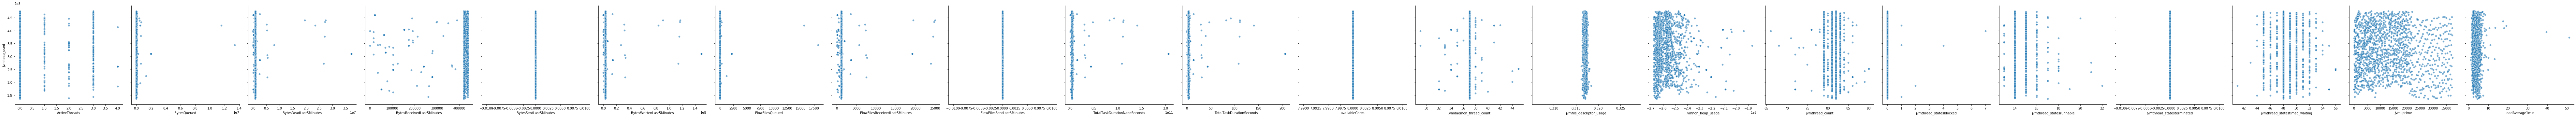

In [12]:
#Perform pairplots on several variables of interest for features against jvm heap used
correlation_vars = ['ActiveThreads', 'BytesQueued', 'BytesReadLast5Minutes',
       'BytesReceivedLast5Minutes', 'BytesSentLast5Minutes',
       'BytesWrittenLast5Minutes', 'FlowFilesQueued',
       'FlowFilesReceivedLast5Minutes', 'FlowFilesSentLast5Minutes',
       'TotalTaskDurationNanoSeconds', 'TotalTaskDurationSeconds',
       'availableCores', 'jvmdaemon_thread_count', 'jvmfile_descriptor_usage',
       'jvmnon_heap_usage', 'jvmthread_count',
       'jvmthread_statesblocked', 'jvmthread_statesrunnable',
       'jvmthread_statesterminated', 'jvmthread_statestimed_waiting',
       'jvmuptime', 'loadAverage1min']

g = sns.pairplot(data=nifi_metrics,x_vars=correlation_vars, 
                 y_vars=['jvmheap_used'], plot_kws={'alpha':.6}, height=5)

The above features appear to have some which are constant values (not changing) or difficult to ascertain a linear relationship. That was considered when selecting features for models.

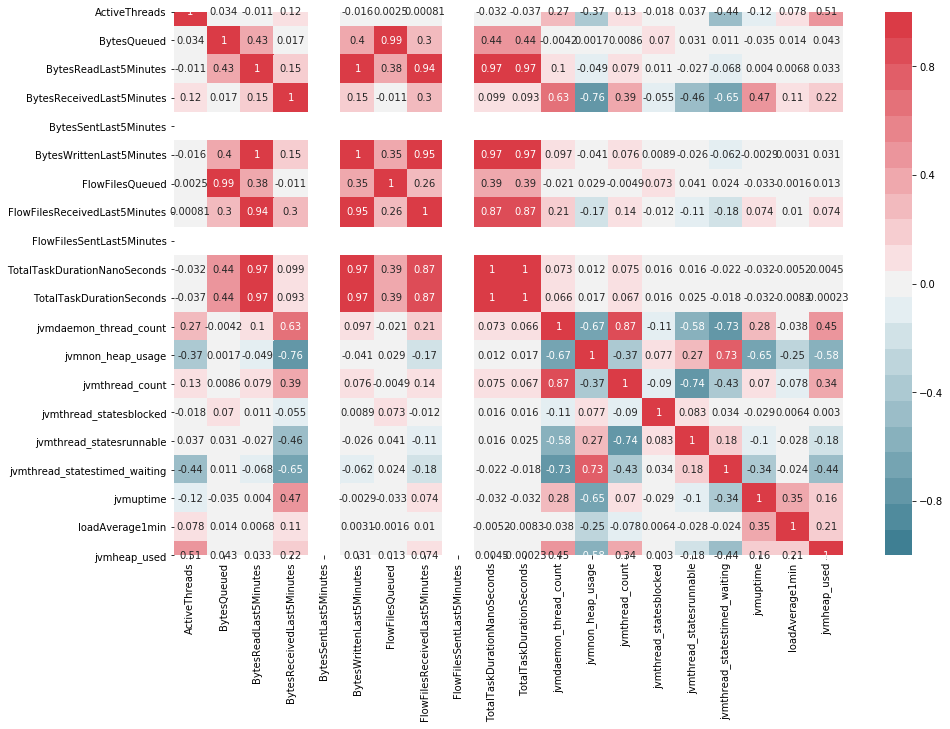

In [13]:
#Create a heatmap with important features

#Remove features that appear to be constant based on pair plot analysis
correlation_vars = ['ActiveThreads', 'BytesQueued', 'BytesReadLast5Minutes',
       'BytesReceivedLast5Minutes', 'BytesSentLast5Minutes',
       'BytesWrittenLast5Minutes', 'FlowFilesQueued',
       'FlowFilesReceivedLast5Minutes', 'FlowFilesSentLast5Minutes',
       'TotalTaskDurationNanoSeconds', 'TotalTaskDurationSeconds', 'jvmdaemon_thread_count', 
       'jvmnon_heap_usage', 'jvmthread_count','jvmthread_statesblocked', 'jvmthread_statesrunnable', 'jvmthread_statestimed_waiting',
       'jvmuptime', 'loadAverage1min','jvmheap_used']

#obtain a correlation matrix
metrics_corr = nifi_metrics.loc[:,correlation_vars].corr()

#visualize correlations with a heatmap
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(metrics_corr,
            vmin=-1,
            vmax=1,
            cmap=sns.diverging_palette(220, 10, n=21),
            annot=True,
            ax=ax,
           );

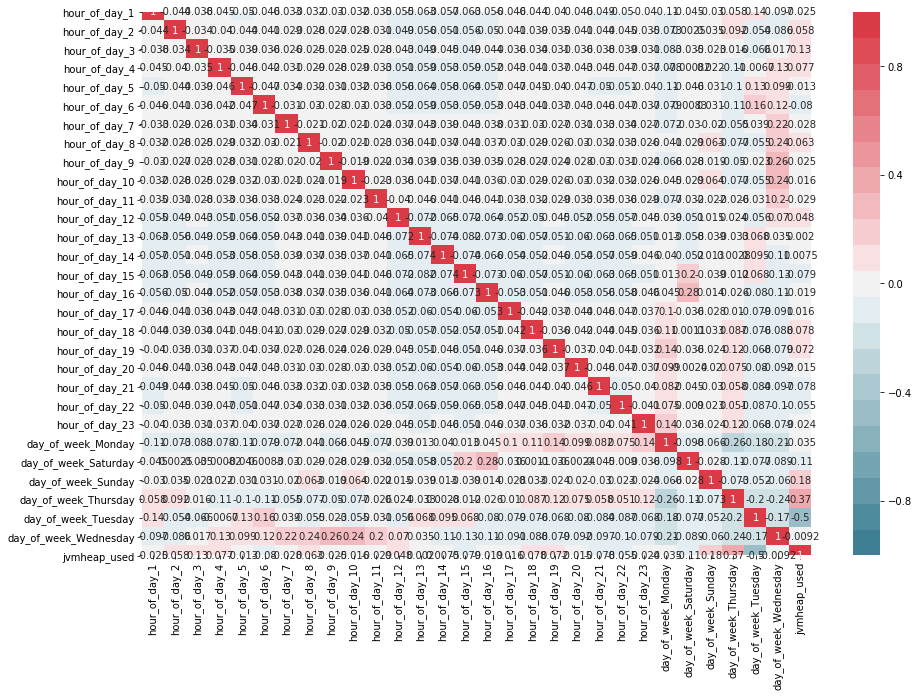

In [14]:
# confirm if certain hours of the day or days of the week would also be useful in determining heap usage
correlation_vars = time_cols + day_cols + ['jvmheap_used']

#obtain a correlation matrix
metrics_corr = nifi_metrics.loc[:,correlation_vars].corr()

#visualize correlations with a heatmap
fig, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(metrics_corr,
            vmin=-1,
            vmax=1,
            cmap=sns.diverging_palette(220, 10, n=21),
            annot=True,
            ax=ax,
           );

Both correlations indicate there are reasonably stron correlations with jvmheap_used and days of the week vs the hours of the day.  So model will use that along with the strongest features that appeared in the first heatmap ('ActiveThreads', 'BytesReceivedLast5Minutes', 'jvmthread_count', 'loadAverage1min')

## 5. Model Building 

### 5.1 Linear Regression Model

In [15]:
#1. Define variables based on correlations
feature_cols = ['ActiveThreads', 'BytesReceivedLast5Minutes', 'jvmthread_count', 'loadAverage1min']
feature_cols += day_cols

X = nifi_metrics.loc[:, feature_cols]
y = nifi_metrics.loc[:, 'jvmheap_used']

In [16]:
#Use RMSE with negative values for appropriate sort order in GridSearchCV (higher is better)
def neg_rmse(y_true, y_pred):
    mse = np.square(y_true - y_pred).mean()
    return -np.sqrt(mse)

#Define 2 scorers to use when training to better understand performance of model
neg_rmse = make_scorer(neg_rmse) 
r2 = make_scorer(metrics.r2_score)

In [17]:
#Using PolynomialFeatures create interaction variables and include in selected features
pf = PolynomialFeatures(interaction_only=True, include_bias=False)
pf.fit(X)
X_poly = pf.transform(X) 

In [18]:
#Perform a cross validation using 10 folds of train-test splits

#Define multiple scorers for cross validation
multi_scoring = {'neg_rmse': neg_rmse,'r2':r2}

#setup KFold to use 10 splits
kf = KFold(10, shuffle=True)

#Instantiate grid search, fit and obtain results
lr_grid = GridSearchCV(estimator=LinearRegression(), param_grid={}, cv=kf, refit='r2', return_train_score=True, scoring=multi_scoring)
lr_grid.fit(X_poly,y)
lr_results = lr_grid.cv_results_

In [19]:
#Obtain and print results
lr_train_r2 =  lr_results['mean_train_r2'][0]
lr_test_r2 =  lr_results['mean_test_r2'][0]
lr_train_rmse_mb = lr_results['mean_train_neg_rmse'][0] * -.000001
lr_test_rmse_mb = lr_results['mean_test_neg_rmse'][0] *-.000001

#Print R**2 scores
print("R**2 - Train Score :", lr_train_r2)
print("R**2 - Test Score :", lr_test_r2)

#Convert RMSE to megabytes and print so that we can understand the error within the appropriate context (memory estimated error)
print("Training RMSE Heap Used in Megabytes:", lr_train_rmse_mb)
print("Test RMSE Heap Used in Megabytes:", lr_test_rmse_mb)

R**2 - Train Score : 0.6708202688615886
R**2 - Test Score : 0.6583508317270269
Training RMSE Heap Used in Megabytes: 55.97680241357447
Test RMSE Heap Used in Megabytes: 56.92120243244592


### 5.2 RandomForest Model

In [20]:
#Create a range for max tree depth setting for varying tree depth in the forest
max_depth_range = range(1, len(feature_cols) + 1)

# Create a range for number of estimators in the forest
forest_range = range(10,100,10)

#Create Forest with random_state set
rf = RandomForestRegressor(random_state = 1)

In [21]:
#Do the cupid, I mean the KFold shuffle with 10 folds
kf = KFold(10, shuffle=True)

#Instantiate grid search, fit and obtain results
rf_grid = GridSearchCV(estimator=rf, 
                       param_grid={'max_depth': max_depth_range,'n_estimators':forest_range}, 
                       cv=kf, 
                       refit='r2',
                       return_train_score=True, 
                       scoring=multi_scoring)
rf_grid.fit(X,y)
rf_results = rf_grid.cv_results_

In [22]:
#Obtain the best estimator from the set for our model of choice
rf_grid.best_score_, rf_grid.best_params_

(0.6842760892450032, {'max_depth': 6, 'n_estimators': 90})

In [23]:
#Create a dataframe from the results object select the best result estimator scores
rfdf = pd.DataFrame(rf_results)
best_result = rfdf[(rfdf.param_n_estimators == 90) & (rfdf.param_max_depth == 4)]
best_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_neg_rmse,split1_test_neg_rmse,split2_test_neg_rmse,...,split2_train_r2,split3_train_r2,split4_train_r2,split5_train_r2,split6_train_r2,split7_train_r2,split8_train_r2,split9_train_r2,mean_train_r2,std_train_r2
35,0.318297,0.022264,0.022402,0.004011,4,90,"{'max_depth': 4, 'n_estimators': 90}",-5.794676e+07,-5.659581e+07,-6.115217e+07,...,0.701613,0.693785,0.691235,0.689337,0.694078,0.699866,0.695755,0.690734,0.695707,0.004463


In [24]:
#Obtain and print scores from best estimator
rf_train_r2 = best_result.loc[35,'mean_train_r2']
rf_test_r2 = best_result.loc[35,'mean_test_r2']
rf_train_rmse_mb = best_result.loc[35,'mean_train_neg_rmse']* -.000001
rf_test_rmse_mb =  best_result.loc[35,'mean_test_neg_rmse']* -.000001

#Print R**2 scores 
print("R**2 - Train Score :", rf_train_r2)
print("R**2 - Test Score :", rf_test_r2)

#Convert RMSE to megabytes and print so that we can understand the error within the appropriate context (memory estimated error)
print("Training RMSE Heap Used in Megabytes:", rf_train_rmse_mb)
print("Test RMSE Heap Used in Megabytes:", rf_test_rmse_mb)

R**2 - Train Score : 0.6957070217918837
R**2 - Test Score : 0.6770547059674279
Training RMSE Heap Used in Megabytes: 53.81777480244
Test RMSE Heap Used in Megabytes: 55.27323772620375


## 6. Model Evaluation

Both models appear to do well in comparison to the null model as evident by their R-squared Scores.  For the Linear Regression model the variance is lower yet predictions are not as accurate as the Random Forest model.  In Random Forest model the predictions perform better than the Linear model on the test and training sets yet there is a higher variance.

In [25]:
#Create a results summary table
model_type = ['LinearRegression', 'RandomForest']
r2_training_results = [lr_train_r2, rf_train_r2]
rmse_training_results = [lr_train_rmse_mb, rf_train_rmse_mb]
r2_test_results = [lr_test_r2, rf_test_r2]
rmse_test_results = [lr_test_rmse_mb, rf_test_rmse_mb]


results_df = pd.DataFrame({'model_type':model_type, 'r2_training_results':r2_training_results,
                           'rmse_training_results':rmse_training_results, 
                           'r2_test_results':r2_test_results,
                           'rmse_test_results':rmse_test_results,})
results_df


,model_type,r2_training_results,rmse_training_results,r2_test_results,rmse_test_results
0,LinearRegression,0.670820,55.976802,0.658351,56.921202
1,RandomForest,0.695707,53.817775,0.677055,55.273238


The decision at this point is whether to proceed with the model that has a slightly higher prediction capability 
yet with slightly greater variance or to use the model with lower variance?